In [1]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

## Select data

In [3]:
# Configure file and folder names
main_folder = os.path.dirname(os.path.dirname(os.getcwd()))
datafolder = main_folder + "/data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 64


## Compute VAEP values

In [5]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions:   0%|          | 0/64 [00:00<?, ?it/s]

Rating actions: 100%|██████████| 64/64 [00:19<00:00,  3.28it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'duration', 'start_x', 'start_y', 'end_x', 'end_y',
       'type_id', 'result_id', 'bodypart_id', 'action_id', 'type_name',
       'result_name', 'bodypart_name', 'player_name', 'nickname', 'team_name',
       'scores', 'concedes', 'offensive_value', 'defensive_value',
       'vaep_value'],
      dtype='object')

## Analyse VAEP ratings
### Most valuable players

In [6]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
152,5186.0,Denis Cheryshev,3.368055,4.017451,-0.649396,213
6,3009.0,Kylian Mbappé,3.035998,3.245628,-0.209630,489
50,3308.0,Kieran Trippier,2.998108,3.652082,-0.653974,684
352,5574.0,Toni Kroos,2.755327,2.860905,-0.105578,641
44,3289.0,Romelu Lukaku,2.712044,2.944010,-0.231966,248
525,6196.0,Yerry Mina,2.697912,2.787133,-0.089221,324
71,3501.0,Philippe Coutinho,2.686655,2.710765,-0.024109,697
121,4319.0,Edinson Cavani,2.580361,2.722565,-0.142203,224
593,10955.0,Harry Kane,2.542931,3.722040,-1.179109,325
36,3244.0,John Stones,2.489336,2.316048,0.173288,935


In [7]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
152,5186.0,Denis Cheryshev,3.368055,4.017451,-0.649396,213,317,0.956230,1.140601,-0.184371
352,5574.0,Toni Kroos,2.755327,2.860905,-0.105578,641,295,0.840608,0.872818,-0.032210
251,5473.0,Ahmed Musa,1.756580,1.838840,-0.082261,161,224,0.705769,0.738820,-0.033051
525,6196.0,Yerry Mina,2.697912,2.787133,-0.089221,324,374,0.649230,0.670701,-0.021470
121,4319.0,Edinson Cavani,2.580361,2.722565,-0.142203,224,362,0.641526,0.676881,-0.035354
34,3237.0,Sergio Agüero,1.692489,1.705037,-0.012548,137,243,0.626848,0.631495,-0.004647
164,5198.0,Diego Costa,1.979645,2.115623,-0.135978,173,322,0.553317,0.591323,-0.038006
16,3083.0,Son Heung-Min,1.740148,1.871172,-0.131024,227,294,0.532698,0.572808,-0.040110
71,3501.0,Philippe Coutinho,2.686655,2.710765,-0.024109,697,458,0.527945,0.532683,-0.004738
75,3531.0,Mohamed Salah,1.139503,1.257775,-0.118271,121,195,0.525925,0.580511,-0.054587


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-06-23 14:00:00 Belgium 5-2 Tunisia 91' dribble Michy Batshuayi Tunga


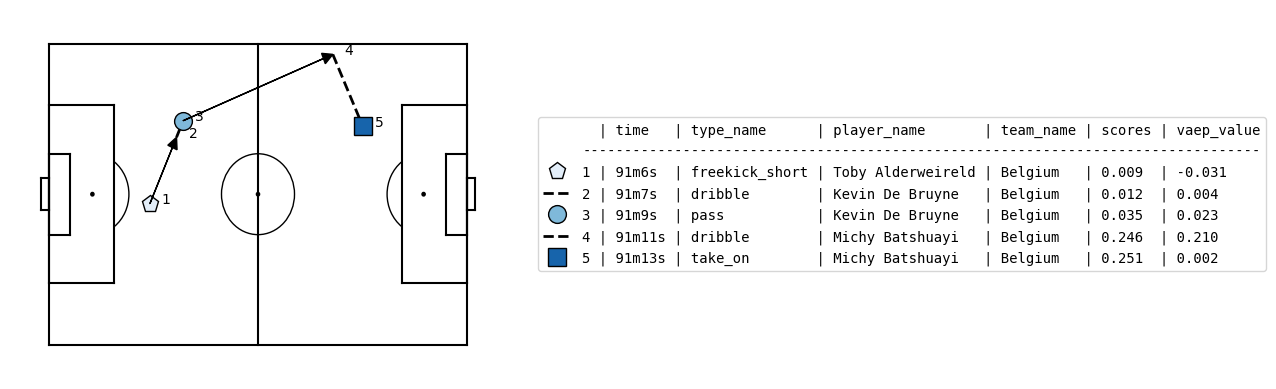

2018-07-06 20:00:00 Brazil 1-2 Belgium 61' dribble Vincent Kompany


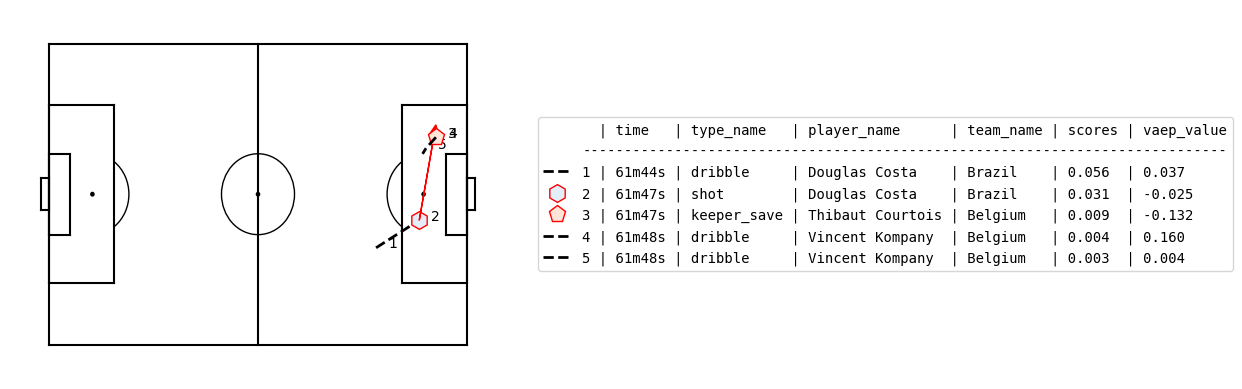

2018-06-23 14:00:00 Belgium 5-2 Tunisia 67' dribble Yannick Ferreira Carrasco


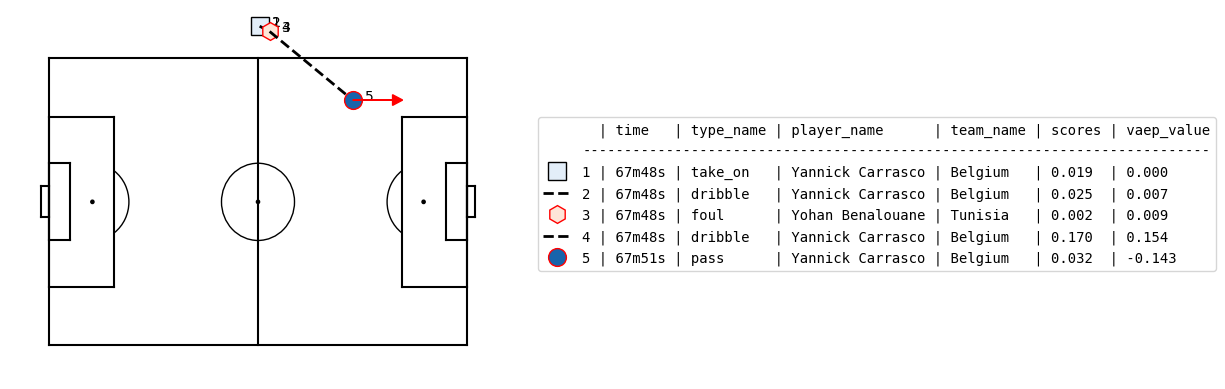

2018-07-02 20:00:00 Belgium 3-2 Japan 88' dribble Nacer Chadli


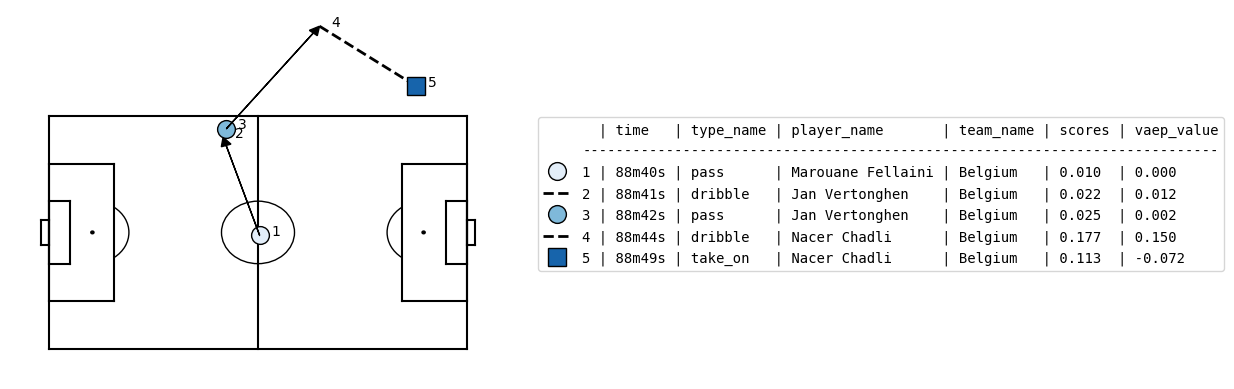

2018-06-23 14:00:00 Belgium 5-2 Tunisia 80' dribble Kevin De Bruyne


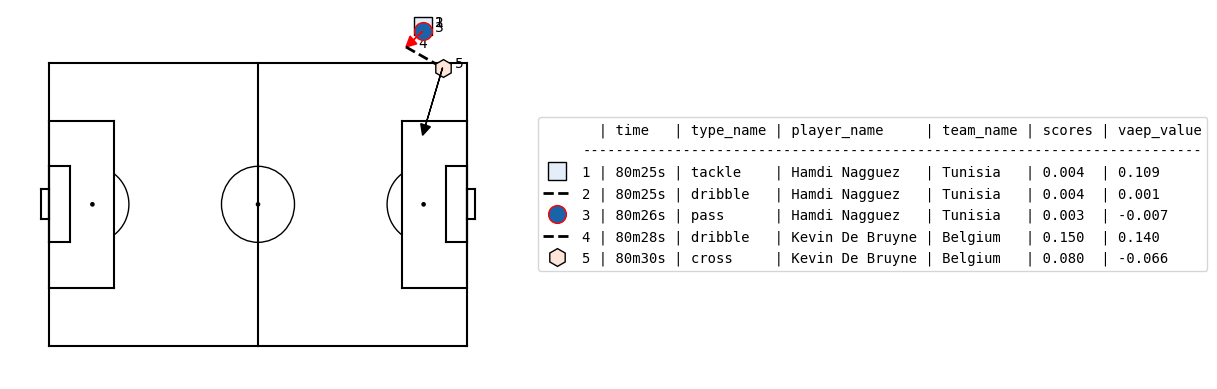

2018-07-14 16:00:00 Belgium 2-0 England 81' dribble Eden Hazard


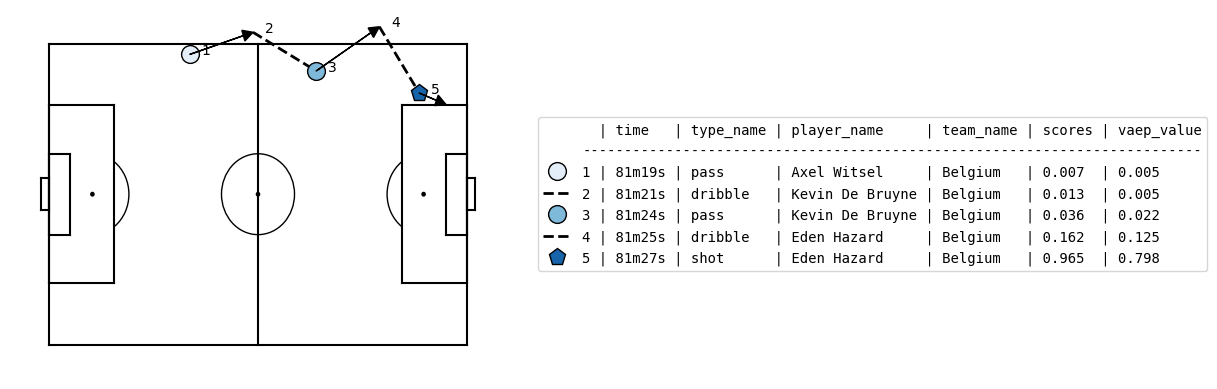

2018-06-23 14:00:00 Belgium 5-2 Tunisia 89' cross Youri Tielemans


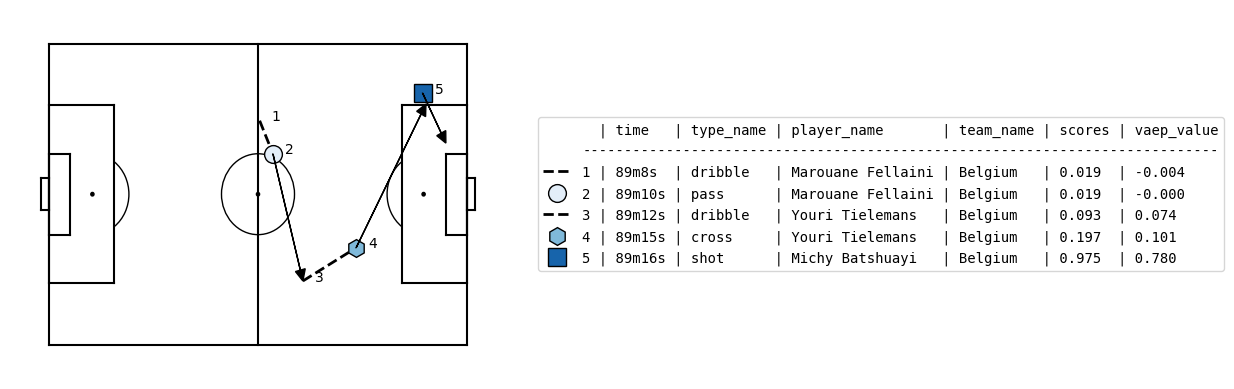

2018-07-02 20:00:00 Belgium 3-2 Japan 73' cross Eden Hazard


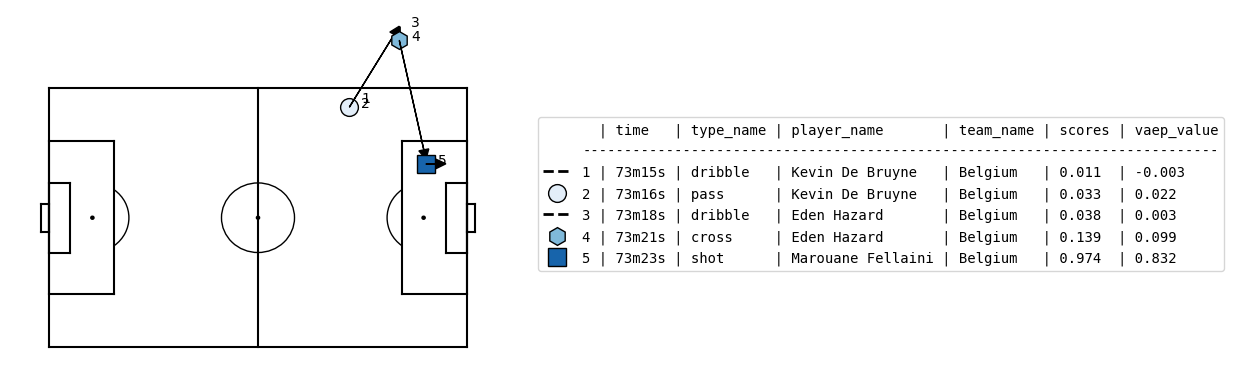

2018-06-18 17:00:00 Belgium 3-0 Panama 68' pass Kevin De Bruyne


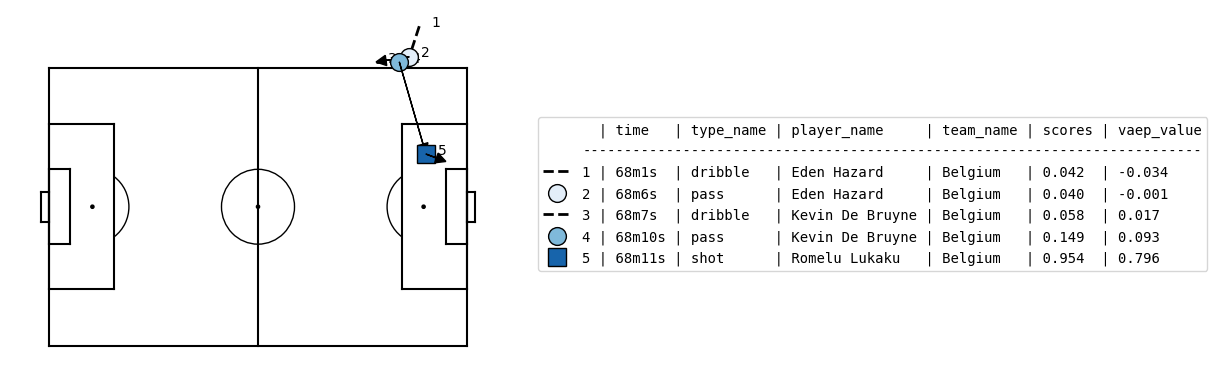

2018-07-02 20:00:00 Belgium 3-2 Japan 77' cross Nacer Chadli


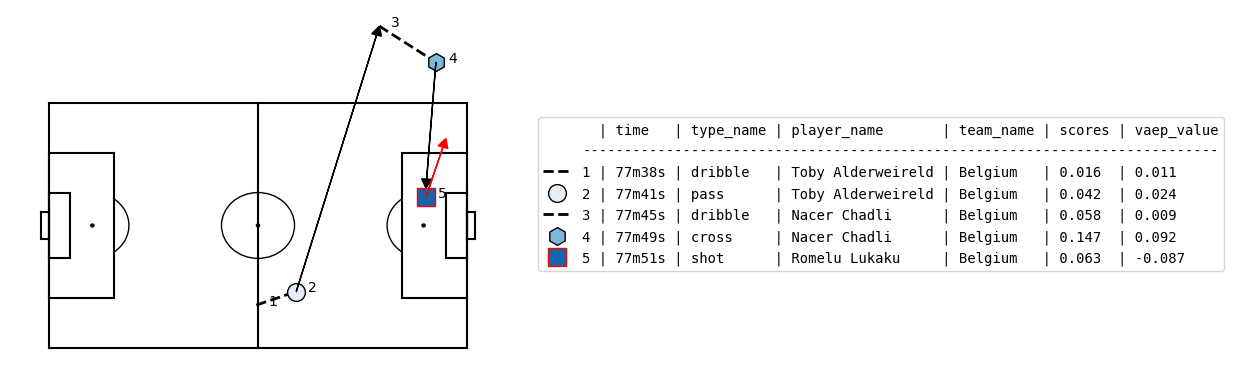

In [8]:
import matplotsoccer

sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = int(time_seconds % 60)
    return f"{m}m{s}s"

for j in range(0, 10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id", "time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "vaep_value"]
    matplotsoccer.actions(a[["start_x", "start_y", "end_x",  "end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)